In [3]:
import os
import glob

from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader, Dataset
from torchvision import models, transforms

plt.rcParams['text.usetex'] = True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda:0


## Data Preprocessing

In [ ]:
!unzip -q "archive.zip"
!rm -rf "data"

In [ ]:
!mkdir "data" "data/l_values" "data/a_values" "data/b_values"

In [5]:
files = glob.glob("natural_images/*/*.jpg")

def preprocess_lab(files, path):
    for i, img_file in enumerate(tqdm(files)):
        rgb_image = imread(img_file)
        lab_image = rgb2lab(rgb_image)
        l, a, b = lab_image[:, :, 0], lab_image[:, :, 1], lab_image[:, :, 2]
        np.save(os.path.join(path, "l_values", f"{i}.npy"), l)
        np.save(os.path.join(path, "a_values", f"{i}.npy"), a)
        np.save(os.path.join(path, "b_values", f"{i}.npy"), b)

def load_lab(path, i, resize_dims=None):
    l = np.load(os.path.join(path, "l_values", f"{i}.npy"))
    a = np.load(os.path.join(path, "a_values", f"{i}.npy"))
    b = np.load(os.path.join(path, "b_values", f"{i}.npy"))
    if resize_dims:
        l = resize(l, resize_dims)
        a = resize(a, resize_dims)
        b = resize(b, resize_dims)
    return l, a, b       

In [ ]:
preprocess_lab(files, "data")

  0%|          | 0/6899 [00:00<?, ?it/s]

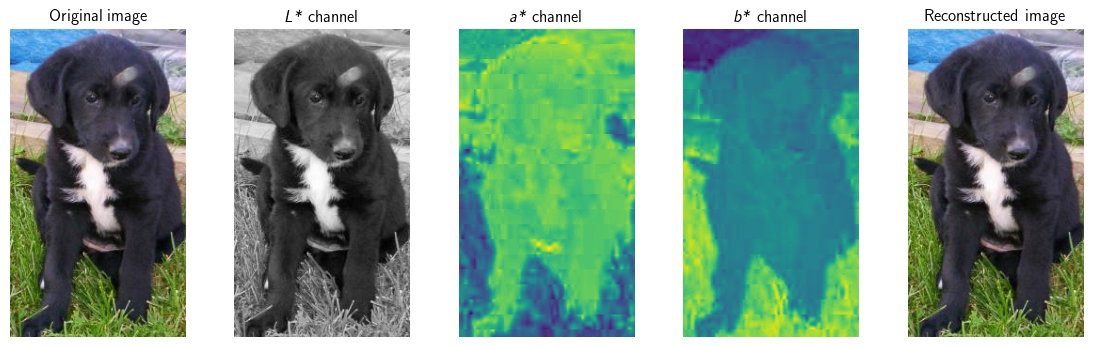

In [6]:
def demo_lab(i, save=False):
    rgb_old = imread(files[i])
    l, a, b = load_lab("data", i)
    rgb_new = lab2rgb(np.stack((l, a, b), axis=2))
    
    plt.figure(figsize=(14, 4))
    plt.subplot(151), plt.imshow(rgb_old), plt.axis("off"), plt.title("Original image")
    plt.subplot(152), plt.imshow(l, cmap="gray"), plt.axis("off"), plt.title(r"\textit{L*} channel")
    plt.subplot(153), plt.imshow(a), plt.axis("off"), plt.title(r"\textit{a*} channel")
    plt.subplot(154), plt.imshow(b), plt.axis("off"), plt.title(r"\textit{b*} channel")
    plt.subplot(155), plt.imshow(rgb_new), plt.axis("off"), plt.title("Reconstructed image")
    
    plt.savefig("demo_lab.png", dpi=400, bbox_inches="tight", transparent=True) if save else plt.show()

demo_lab(204, True)

## Data Loading

In [7]:
class LABDataset(Dataset):
    
    def __init__(self, path, dims=(224, 224)):
        self.path = path
        self.dims = dims
    
    def __len__(self):
        return min([len(os.listdir(os.path.join(self.path, subdir)))
                    for subdir in ["l_values", "a_values", "b_values"]])
    
    def __getitem__(self, i):
        l, a, b = load_lab(self.path, i, resize_dims=self.dims)
        inputs = np.repeat(np.expand_dims(l, axis=0), 3, axis=0)
        targets = np.stack((a, b), axis=0)
        return i, inputs, targets

In [8]:
dataset = LABDataset("data", dims=(224, 224))

RAND_SEED = 42

train_idx, test_idx = train_test_split(np.arange(len(dataset)), train_size=0.8, test_size=0.2, random_state=RAND_SEED)
train_idx, valid_idx = train_test_split(train_idx, train_size=0.8, test_size=0.2, random_state=RAND_SEED)

datasets = {
    "train": Subset(dataset, train_idx),
    "valid": Subset(dataset, valid_idx),
    "test": Subset(dataset, test_idx)
}

In [9]:
batch_sizes = {"train": 100, "valid": 100, "test": 100}
dataloaders = {phase: DataLoader(dataset, batch_size=batch_sizes[phase], shuffle=True)
               for phase, dataset in datasets.items()}

for phase in datasets.keys():
    print(f"{phase.capitalize()} set:\t{len(datasets[phase])} images ({len(dataloaders[phase])} batches)")

Train set:	4415 images (45 batches)
Valid set:	1104 images (12 batches)
Test set:	1380 images (14 batches)


In [10]:
def merge_lab(l3, ab):
    input_img = (l3 / 100 * 255).astype(dtype=np.int32)
    output_img = np.concatenate((l3[:, 0:1], ab), axis=1)
    return np.moveaxis(input_img, 1, -1), np.moveaxis(output_img, 1, -1)

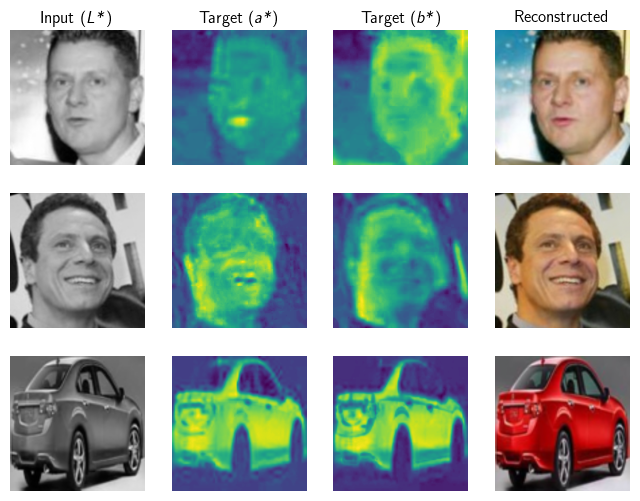

In [11]:
def demo_dataloader(N=3, save=False):
    _, inputs, targets = next(iter(dataloaders["test"]))
    inputs, targets = inputs.numpy(), targets.numpy()
    idx = np.random.choice(np.arange(len(inputs)), size=N, replace=False)
    inputs, targets = merge_lab(inputs[idx], targets[idx])
    
    plt.figure(figsize=(8, N*2))
    
    for i in range(N):
        input_img = inputs[i]
        target_img = lab2rgb(targets[i])
        plt.subplot(N, 4, i*4+1), plt.imshow(input_img), plt.axis("off"), plt.title(r"Input (\textit{L*})") if i == 0 else None
        plt.subplot(N, 4, i*4+2), plt.imshow(targets[i,:,:,1]), plt.axis("off"), plt.title(r"Target (\textit{a*})") if i == 0 else None
        plt.subplot(N, 4, i*4+3), plt.imshow(targets[i,:,:,2]), plt.axis("off"), plt.title(r"Target (\textit{b*})") if i == 0 else None
        plt.subplot(N, 4, i*4+4), plt.imshow(target_img), plt.axis("off"), plt.title("Reconstructed") if i == 0 else None
    
    plt.savefig("demo_loader.png", dpi=400, bbox_inches="tight", transparent=True) if save else plt.show()

demo_dataloader(3, save=True)

## Training & Utility Methods

In [108]:
def train_model(model, loss_fn, optimizer, num_epochs=20, patience=5, best_loss=None, scheduler=None, save_filename="model.pt"):
    
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f"EPOCH {epoch + 1} / {num_epochs}")
        
        for phase in ["train", "valid"]:
            running_loss = 0
            model.train() if phase == "train" else model.eval()
            batches = tqdm(dataloaders[phase], desc=phase.title(), leave=False, colour="green")
            for _, inputs, targets in batches:
                inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0)
            running_loss /= len(datasets[phase])
            print(f"{phase.title()} Loss: {running_loss:.7f}")

        if not best_loss or running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(), save_filename)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter == patience:
                print(f"\nStopped training early after {patience} epochs without improving validation loss")
                break
        
        if scheduler:
            scheduler.step()
        print("")
    
    model.load_state_dict(torch.load(save_filename))
    return model, best_loss

## Approach 1: L2 Regression

### Model Architecture

In [12]:
class RegressionColorizer(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        pretrained_resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet = nn.Sequential(
            pretrained_resnet.conv1,
            pretrained_resnet.bn1,
            pretrained_resnet.maxpool,
            pretrained_resnet.layer1,
            pretrained_resnet.layer2,
            pretrained_resnet.layer3,
            pretrained_resnet.layer4
        )
        
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),
        )
        
        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample = nn.Upsample(scale_factor=16, mode="bilinear")
    
    def forward(self, input_l):
        out1 = self.resnet(self.normalize_l(input_l))
        out2 = self.layer5(out1)
        out3 = self.model_out(self.softmax(out2))
        return self.unnormalize_ab(self.upsample(out3))
    
    def normalize_l(self, in_l):
        return (in_l - 50) / 100

    def unnormalize_ab(self, in_ab):
        return in_ab * 110

### Model Training — Large Batches

In [116]:
model = RegressionColorizer().to(device)

for param in model.resnet.parameters():
    param.requires_grad = False

In [118]:
loss_fn = torch.nn.MSELoss()

params_to_update = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.Adam(params_to_update, lr=0.0001)

model, loss = train_model(model, loss_fn, optimizer, num_epochs=5, save_filename="regr-resnet-large-0.pt")

EPOCH 1 / 5


Train:   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 271.0336383


Valid:   0%|          | 0/12 [00:00<?, ?it/s]

Valid Loss: 272.2270880

EPOCH 2 / 5


Train:   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 263.3012670


Valid:   0%|          | 0/12 [00:00<?, ?it/s]

Valid Loss: 262.4381525

EPOCH 3 / 5


Train:   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 254.9514599


Valid:   0%|          | 0/12 [00:00<?, ?it/s]

Valid Loss: 258.4287402

EPOCH 4 / 5


Train:   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 250.2314792


Valid:   0%|          | 0/12 [00:00<?, ?it/s]

Valid Loss: 254.4474467

EPOCH 5 / 5


Train:   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 244.3170194


Valid:   0%|          | 0/12 [00:00<?, ?it/s]

Valid Loss: 248.2552916



### Model Training — Small Batches

In [115]:
model = RegressionColorizer().to(device)

for param in model.resnet.parameters():
    param.requires_grad = False

#### Feature Extraction

In [ ]:
loss_fn = torch.nn.MSELoss()

params_to_update = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.Adam(params_to_update, lr=0.0001)

model, loss = train_model(model, loss_fn, optimizer, num_epochs=25, save_filename="regr-resnet-0.pt")

EPOCH 1 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 263.2831206


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 253.8355195

EPOCH 2 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 240.9675941


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 237.2266620

EPOCH 3 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 228.5628488


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 229.4399305

EPOCH 4 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 217.5612375


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 220.9290816

EPOCH 5 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 210.5802142


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 219.2505822

EPOCH 6 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 203.8285696


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 213.8440029

EPOCH 7 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 198.6450298


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 209.7703648

EPOCH 8 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 194.3814549


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 209.8838981

EPOCH 9 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 187.7920214


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 206.7459774

EPOCH 10 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 182.9739033


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 204.1775538

EPOCH 11 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 176.6988414


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 200.8085750

EPOCH 12 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 172.2710140


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 198.4070039

EPOCH 13 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 165.7296614


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 197.5677313

EPOCH 14 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 158.7500841


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 200.5619757

EPOCH 15 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 154.5683796


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 197.6017816

EPOCH 16 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 149.1215055


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 194.2436280

EPOCH 17 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 144.0016516


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 195.5540949

EPOCH 18 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 138.6751873


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 199.0262277

EPOCH 19 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 134.3747024


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 195.9230582

EPOCH 20 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 130.1590470


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 198.1996496

EPOCH 21 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 125.7963759


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 197.3734093

Stopped training early after 5 epochs without improving validation loss


#### Fine-Tuning

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lambda1 = lambda epoch: 0.85 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

model, loss = train_model(model, loss_fn, optimizer, scheduler=scheduler, best_loss=loss, num_epochs=25, save_filename="regr-resnet-1.pt")

EPOCH 1 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 175.9150343


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 193.9343150

EPOCH 2 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 150.2784843


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 186.6037327

EPOCH 3 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 131.1245724


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 181.8329166

EPOCH 4 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 116.9562763


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 179.9771291

EPOCH 5 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 107.1422363


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 178.1537195

EPOCH 6 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 100.2438930


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 175.9509096

EPOCH 7 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 95.0761968


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 174.7793024

EPOCH 8 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 90.3316933


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 175.7457949

EPOCH 9 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 86.8621514


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 175.0060268

EPOCH 10 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 83.7648473


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 174.6281810

EPOCH 11 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 81.4295760


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 175.7298001

EPOCH 12 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 79.3135355


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 173.9247182

EPOCH 13 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 77.5632538


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 173.9616539

EPOCH 14 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 76.0225492


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 172.9246591

EPOCH 15 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 75.0266056


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 173.4037856

EPOCH 16 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 73.8810455


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 174.6564854

EPOCH 17 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 72.8162870


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 174.4627990

EPOCH 18 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 72.1997010


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 174.5491521

EPOCH 19 / 25


Train:   0%|          | 0/442 [00:00<?, ?it/s]

Train Loss: 71.5232309


Valid:   0%|          | 0/37 [00:00<?, ?it/s]

Valid Loss: 174.9699405

Stopped training early after 5 epochs without improving validation loss


### Colorization Results

In [18]:
model.load_state_dict(torch.load("regr-resnet-1.pt"))

<All keys matched successfully>

In [119]:
def show_sample_results(model, N=5):
    _, inputs, targets = next(iter(dataloaders["test"]))
    outputs = model(inputs.to(device, dtype=torch.float))
    inputs = inputs.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    
    idx = np.random.choice(np.arange(len(inputs)), size=N, replace=False)
    _, outputs = merge_lab(inputs[idx], outputs[idx])
    inputs, targets = merge_lab(inputs[idx], targets[idx])
    
    plt.figure(figsize=(6, N*2))
    for i in range(N):
        input_img = inputs[i]
        output_img = lab2rgb(outputs[i])
        target_img = lab2rgb(targets[i])
        plt.subplot(N, 3, i*3+1); plt.imshow(input_img); plt.axis("off")
        plt.subplot(N, 3, i*3+2); plt.imshow(output_img); plt.axis("off")
        plt.subplot(N, 3, i*3+3); plt.imshow(target_img); plt.axis("off")
    plt.show()

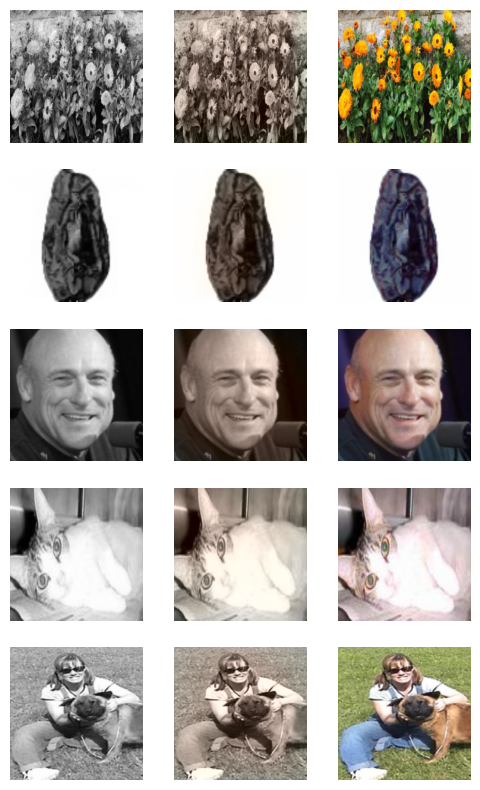

In [120]:
show_sample_results(model, N=5)

## Approach 2: Multinomial Classification

### Model Architecture

In [13]:
class ClassificationColorizer(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        pretrained_resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet = nn.Sequential(
            pretrained_resnet.conv1,
            pretrained_resnet.bn1,
            pretrained_resnet.maxpool,
            pretrained_resnet.layer1,
            pretrained_resnet.layer2,
            pretrained_resnet.layer3,
            pretrained_resnet.layer4
        )
        
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),
        )

        # self.softmax = nn.Softmax(dim=1)
        self.upsample = nn.Upsample(scale_factor=16, mode="bilinear")
    
    def forward(self, input_l):
        out1 = self.resnet(self.normalize_l(input_l))
        out2 = self.layer5(out1)
        # return self.upsample(self.softmax(out2))
        return self.upsample(out2)
    
    def normalize_l(self, in_l):
        return (in_l - 50) / 100

### Model Training — Hard Encoding

In [23]:
model = ClassificationColorizer().to(device)

for param in model.resnet.parameters():
    param.requires_grad = False

In [24]:
from sklearn.neighbors import NearestNeighbors

ab_bins = np.load("pts_in_hull.npy")
prior_probs = torch.Tensor(np.load("prior_probs.npy")).to(device)
nbrs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(ab_bins)

def soft_encode(targets):
    targets_pm = targets.moveaxis(1, -1)
    targets_ab = targets_pm.flatten(end_dim=-2).cpu()
    dist, idx = nbrs.kneighbors(targets_ab)
    dist_inv = 1 / (dist + 1)
    w = dist_inv / np.sum(dist_inv, axis=1)[:, None]
    z = np.zeros((len(targets_ab), nbrs.n_samples_fit_))
    z[np.arange(len(targets_ab)), idx.flatten()] = w.flatten()
    z = np.moveaxis(z.reshape(*targets_pm.shape[:-1], -1), -1, 1)
    return torch.Tensor(z).to(device)

def loss_fn(output, target):
    return torch.nn.functional.cross_entropy(output, soft_encode(target), weight=prior_probs)

#### Feature Extraction

In [26]:
params_to_update = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.Adam(params_to_update, lr=0.00001)

lambda1 = lambda epoch: 0.9 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

model, loss = train_model(model, loss_fn, optimizer, scheduler=scheduler, num_epochs=4, save_filename="clss-resnet-hard-0.pt")

EPOCH 1 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.0955035


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.0951363

EPOCH 2 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.0946631


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.0951920

EPOCH 3 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.0944471


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.0947666

EPOCH 4 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.0941019


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.0947297



In [28]:
optimizer = torch.optim.Adam(params_to_update, lr=0.000002)

lambda1 = lambda epoch: 0.9 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

model, loss = train_model(model, loss_fn, optimizer, scheduler=scheduler, best_loss=loss, num_epochs=4, save_filename="clss-resnet-hard-1.pt")

EPOCH 1 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.0930454


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.0947036

EPOCH 2 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.0929823


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.0945024

EPOCH 3 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.0929088


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.0952774

EPOCH 4 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.0929131


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.0943138



#### Fine-Tuning

In [30]:
for param in model.parameters():
    param.requires_grad = True

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

lambda1 = lambda epoch: 0.6 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

model, loss = train_model(model, loss_fn, optimizer, scheduler=scheduler, best_loss=loss, num_epochs=4, save_filename="clss-resnet-hard-2.pt")

EPOCH 1 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.0928785


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.0939198

EPOCH 2 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.0904113


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.0927918

EPOCH 3 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.0889371


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.0924981

EPOCH 4 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.0880418


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.0925881



### Model Training — Soft Encoding

In [12]:
model = ClassificationColorizer().to(device)

for param in model.resnet.parameters():
    param.requires_grad = False

In [13]:
from sklearn.neighbors import NearestNeighbors

ab_bins = np.load("pts_in_hull.npy")
prior_probs = torch.Tensor(np.load("prior_probs.npy")).to(device)
nbrs = NearestNeighbors(n_neighbors=5, algorithm="ball_tree").fit(ab_bins)

def soft_encode(targets):
    targets_pm = targets.moveaxis(1, -1)
    targets_ab = targets_pm.flatten(end_dim=-2).cpu()
    dist, idx = nbrs.kneighbors(targets_ab)
    dist_inv = 1 / (dist + 1)
    w = dist_inv / np.sum(dist_inv, axis=1)[:, None]
    z = np.zeros((len(targets_ab), nbrs.n_samples_fit_))
    z[np.repeat(np.arange(len(targets_ab)), 5), idx.flatten()] = w.flatten()
    z = np.moveaxis(z.reshape(*targets_pm.shape[:-1], -1), -1, 1)
    return torch.Tensor(z).to(device)

def loss_fn(output, target):
    return torch.nn.functional.cross_entropy(output, soft_encode(target), weight=prior_probs)

#### Feature Extraction

In [15]:
params_to_update = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.Adam(params_to_update, lr=0.00001)

lambda1 = lambda epoch: 0.9 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

model, loss = train_model(model, loss_fn, optimizer, scheduler=scheduler, num_epochs=4, save_filename="clss-resnet-2.pt")

EPOCH 1 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1100484


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1099165

EPOCH 2 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1095450


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1101496

EPOCH 3 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1093427


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1101905

EPOCH 4 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1091424


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1094630



In [16]:
optimizer = torch.optim.Adam(params_to_update, lr=0.000005)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

model, loss = train_model(model, loss_fn, optimizer, scheduler=scheduler, best_loss=loss, num_epochs=4, save_filename="clss-resnet-2.pt")

EPOCH 1 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1090227


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1097418

EPOCH 2 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1087687


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1093762

EPOCH 3 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1086641


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1095593

EPOCH 4 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1086644


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1091150



In [23]:
optimizer = torch.optim.Adam(params_to_update, lr=0.000005)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

model, loss = train_model(model, loss_fn, optimizer, scheduler=scheduler, best_loss=loss, num_epochs=4, save_filename="clss-resnet-3.pt")

EPOCH 1 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1086755


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1090448

EPOCH 2 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1085014


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1090201

EPOCH 3 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1085159


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1090019

EPOCH 4 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1084537


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1093156



In [26]:
optimizer = torch.optim.Adam(params_to_update, lr=0.000003)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

model, loss = train_model(model, loss_fn, optimizer, scheduler=scheduler, best_loss=loss, num_epochs=10, save_filename="clss-resnet-4.pt")

EPOCH 1 / 10


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1083845


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1096710

EPOCH 2 / 10


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1083969


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1091346

EPOCH 3 / 10


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1082966


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1089928

EPOCH 4 / 10


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1083212


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1092033

EPOCH 5 / 10


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1082274


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1092572

EPOCH 6 / 10


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1082393


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1090152

EPOCH 7 / 10


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1082475


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1089085

EPOCH 8 / 10


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1082314


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1089083

EPOCH 9 / 10


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1082009


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1090045

EPOCH 10 / 10


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1082103


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1089733



In [27]:
optimizer = torch.optim.Adam(params_to_update, lr=0.000001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

model, loss = train_model(model, loss_fn, optimizer, scheduler=scheduler, best_loss=loss, num_epochs=4, save_filename="clss-resnet-5.pt")

EPOCH 1 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1081450


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1090086

EPOCH 2 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1080928


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1088460

EPOCH 3 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1081609


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1089156

EPOCH 4 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1080858


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1091537



#### Fine-Tuning

In [19]:
for param in model.parameters():
    param.requires_grad = True

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model, loss = train_model(model, loss_fn, optimizer, best_loss=0.1088460, num_epochs=4, save_filename="clss-resnet-6.pt")

EPOCH 1 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1079610


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1081215

EPOCH 2 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1067990


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1076073

EPOCH 3 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1059031


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1075220

EPOCH 4 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1051589


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1081869



In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

lambda1 = lambda epoch: 0.8 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

model, loss = train_model(model, loss_fn, optimizer, scheduler=scheduler, best_loss=loss, num_epochs=4, save_filename="clss-resnet-7.pt")

EPOCH 1 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1035859


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1073419

EPOCH 2 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1025652


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1075321

EPOCH 3 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1018475


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1076387

EPOCH 4 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1013640


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1079299



In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

lambda1 = lambda epoch: 0.8 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

model, loss = train_model(model, loss_fn, optimizer, scheduler=scheduler, best_loss=loss, num_epochs=4, save_filename="clss-resnet-8.pt")

EPOCH 1 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Train Loss: 0.1024399


Valid:   0%|          | 0/138 [00:00<?, ?it/s]

Valid Loss: 0.1074473

EPOCH 2 / 4


Train:   0%|          | 0/552 [00:00<?, ?it/s]

### Colorization Results

In [32]:
def colorize(model, inputs, method="mode"):
    outputs = model(inputs.to(device, dtype=torch.float))
    if method == "mode":
        outputs = torch.argmax(outputs, 1).cpu().numpy()
        return np.moveaxis(ab_bins[outputs], -1, 1)
    elif method == "mean":
        outputs = torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()
        return np.moveaxis(np.tensordot(ab_bins, outputs, axes=([0], [1])), 0, 1)
    raise ValueError("method can either be mean or mode")

In [33]:
def show_sample_results(model, N=5, method="mode"):
    _, inputs, targets = next(iter(dataloaders["test"]))
    outputs = colorize(model, inputs, method) / 110 * 128
        
    inputs = inputs.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    
    idx = np.random.choice(np.arange(len(inputs)), size=N, replace=False)
    _, outputs = merge_lab(inputs[idx], outputs[idx])
    inputs, targets = merge_lab(inputs[idx], targets[idx])
    
    plt.figure(figsize=(6, N*2))
    for i in range(N):
        input_img = inputs[i]
        output_img = lab2rgb(outputs[i])
        target_img = lab2rgb(targets[i])
        plt.subplot(N, 3, i*3+1); plt.imshow(input_img); plt.axis("off")
        plt.subplot(N, 3, i*3+2); plt.imshow(output_img); plt.axis("off")
        plt.subplot(N, 3, i*3+3); plt.imshow(target_img); plt.axis("off")
    plt.show()

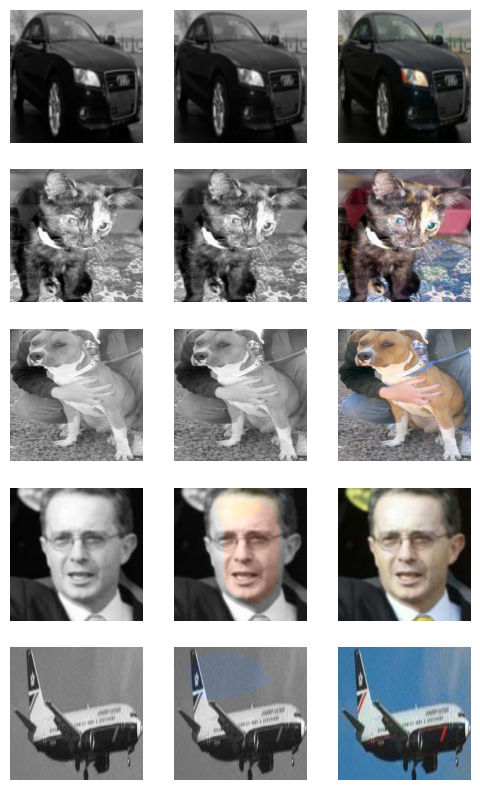

In [36]:
show_sample_results(model, 5, "mode")

## Results

In [14]:
regr_model_s = RegressionColorizer().to(device)
regr_model_s.load_state_dict(torch.load("regr-resnet-1.pt"))

regr_model_l = RegressionColorizer().to(device)
regr_model_l.load_state_dict(torch.load("regr-resnet-large-0.pt"))

clss_model_s = ClassificationColorizer().to(device)
clss_model_s.load_state_dict(torch.load("clss-resnet-7.pt"))

clss_model_h = ClassificationColorizer().to(device)
clss_model_h.load_state_dict(torch.load("clss-resnet-hard-2.pt"))

<All keys matched successfully>

In [15]:
def regression_colorize(model, inputs):
    outputs = model(inputs.to(device, dtype=torch.float))
    inputs, outputs = inputs.cpu().detach().numpy(), outputs.cpu().detach().numpy()
    return merge_lab(inputs, outputs)

In [16]:
def colorize(model, inputs, method="mode"):
    ab_bins = np.load("pts_in_hull.npy")
    outputs = model(inputs.to(device, dtype=torch.float))
    if method == "mode":
        outputs = torch.argmax(outputs, 1).cpu().numpy()
        return np.moveaxis(ab_bins[outputs], -1, 1)
    elif method == "mean":
        outputs = torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()
        return np.moveaxis(np.tensordot(ab_bins, outputs, axes=([0], [1])), 0, 1)
    raise ValueError("method can either be mean or mode")

def classification_colorize(model, inputs, method="mean"):
    outputs = model(inputs.to(device, dtype=torch.float))
    outputs = colorize(model, inputs, method) / 110 * 128
    inputs = inputs.cpu().detach().numpy()
    return merge_lab(inputs, outputs)

In [22]:
def show_sample_results(idx=None, save=False):
    
    if idx is None:
        idx = np.random.choice(np.arange(len(dataset)), size=5, replace=False)
    N = len(idx)
    
    print(idx)
    
    subset = Subset(dataset, idx)
    loader = DataLoader(subset, batch_size=N)
    _, inputs, _ = next(iter(loader))
    
    _, regr_s_out = regression_colorize(regr_model_s, inputs)
    _, regr_l_out = regression_colorize(regr_model_l, inputs)
    _, clss_s_out = classification_colorize(clss_model_s, inputs)
    inputs, clss_h_out = classification_colorize(clss_model_h, inputs)
    
    plt.figure(figsize=(10, N*1.6))
    for i in range(len(idx)):
        input_img = inputs[i]
        regr_s_img = lab2rgb(regr_s_out[i])
        regr_l_img = lab2rgb(regr_l_out[i])
        clss_s_img = lab2rgb(clss_s_out[i])
        clss_h_img = lab2rgb(clss_h_out[i])
        plt.subplot(N, 6, i*6+1), plt.imshow(input_img), plt.axis("off"), plt.title(r"Input (\textit{L*})") if i == 0 else None
        plt.subplot(N, 6, i*6+2), plt.imshow(regr_s_img), plt.axis("off"), plt.title(r"Regr. ($b=16$)") if i == 0 else None
        plt.subplot(N, 6, i*6+3), plt.imshow(regr_l_img), plt.axis("off"), plt.title(r"Regr. ($b=16$)") if i == 0 else None
        plt.subplot(N, 6, i*6+4), plt.imshow(clss_s_img), plt.axis("off"), plt.title(r"Class. ($k=5$)") if i == 0 else None
        plt.subplot(N, 6, i*6+5), plt.imshow(clss_h_img), plt.axis("off"), plt.title(r"Class. ($k=1$)") if i == 0 else None
        plt.subplot(N, 6, i*6+6), plt.imshow(resize(imread(files[idx[i]]), (224, 224))), plt.axis("off"), plt.title(r"Ground Truth") if i == 0 else None
    
    plt.savefig("results.png", dpi=400, bbox_inches="tight", transparent=True) if save else plt.show()

[1255, 3082, 488, 3052, 1843, 2330, 2622, 1579, 6860, 346, 3489]


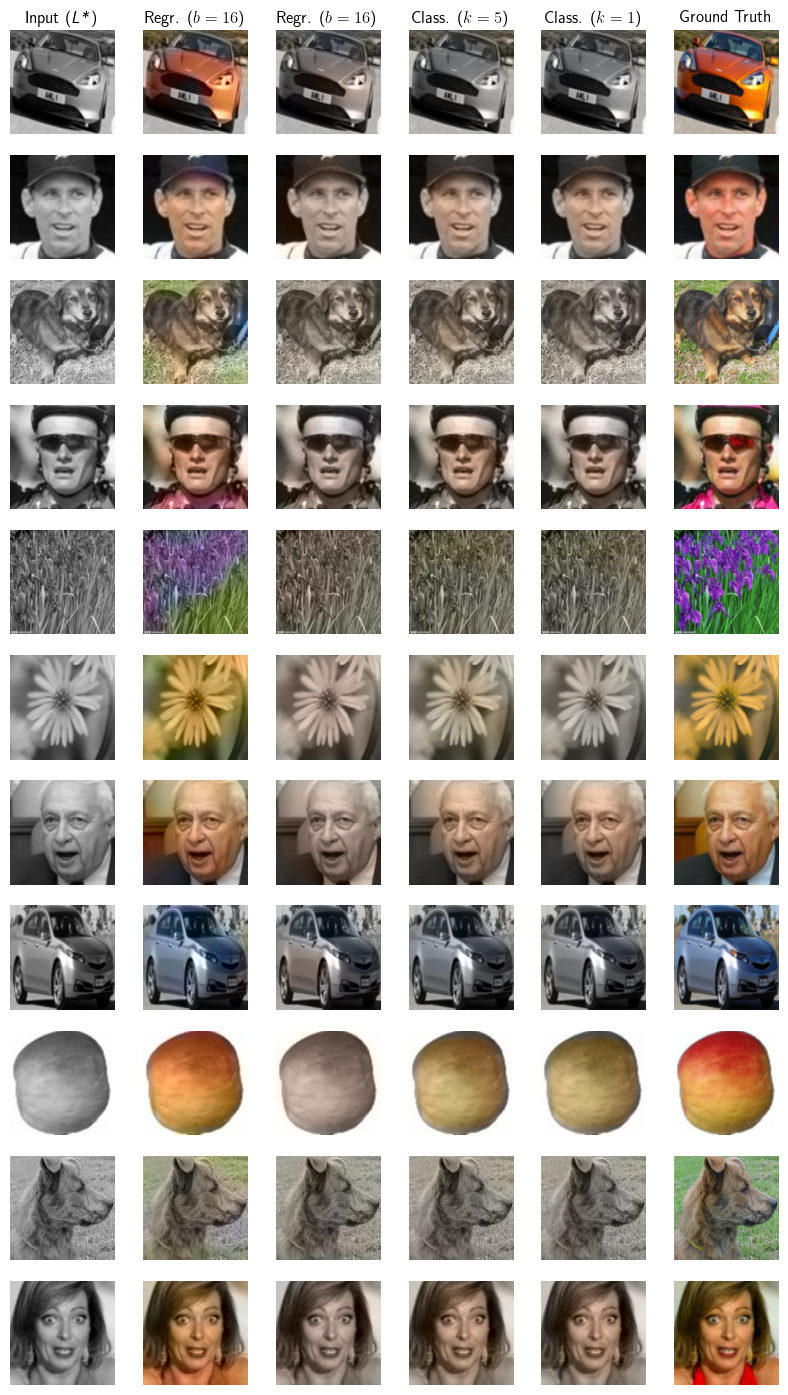

In [23]:
show_sample_results(idx=[1255, 3082, 488, 3052, 1843, 2330, 2622, 1579, 6860, 346, 3489], save=True)

In [24]:
def show_sample_results(idx=None):
    
    if idx is None:
        idx = np.random.choice(np.arange(len(dataset)), size=5, replace=False)
    N = len(idx)
    
    print(idx)
    
    subset = Subset(dataset, idx)
    loader = DataLoader(subset, batch_size=N)
    _, inputs, _ = next(iter(loader))
    
    _, clss_s_mean = classification_colorize(clss_model_s, inputs, method="mean")
    _, clss_s_mode = classification_colorize(clss_model_s, inputs, method="mode")
    _, clss_h_mean = classification_colorize(clss_model_h, inputs, method="mean")
    inputs, clss_h_mode = classification_colorize(clss_model_h, inputs, method="mode")
    
    plt.figure(figsize=(8, N*1.6))
    for i in range(len(idx)):
        input_img = inputs[i]
        s_mean_img = lab2rgb(clss_s_mean[i])
        s_mode_img = lab2rgb(clss_s_mode[i])
        h_mean_img = lab2rgb(clss_h_mean[i])
        h_mode_img = lab2rgb(clss_h_mode[i])
        plt.subplot(N, 5, i*5+1), plt.imshow(input_img), plt.axis("off"), plt.title(r"Input (\textit{L*})") if i == 0 else None
        plt.subplot(N, 5, i*5+2), plt.imshow(s_mean_img), plt.axis("off"), plt.title(r"Mean ($k=5$)") if i == 0 else None
        plt.subplot(N, 5, i*5+3), plt.imshow(s_mode_img), plt.axis("off"), plt.title(r"Mode ($k=5$)") if i == 0 else None
        plt.subplot(N, 5, i*5+4), plt.imshow(h_mean_img), plt.axis("off"), plt.title(r"Mean ($k=1$)") if i == 0 else None
        plt.subplot(N, 5, i*5+5), plt.imshow(h_mode_img), plt.axis("off"), plt.title(r"Mode ($k=1$)") if i == 0 else None
    plt.show()

[3383 6170 1741 2987 6567]


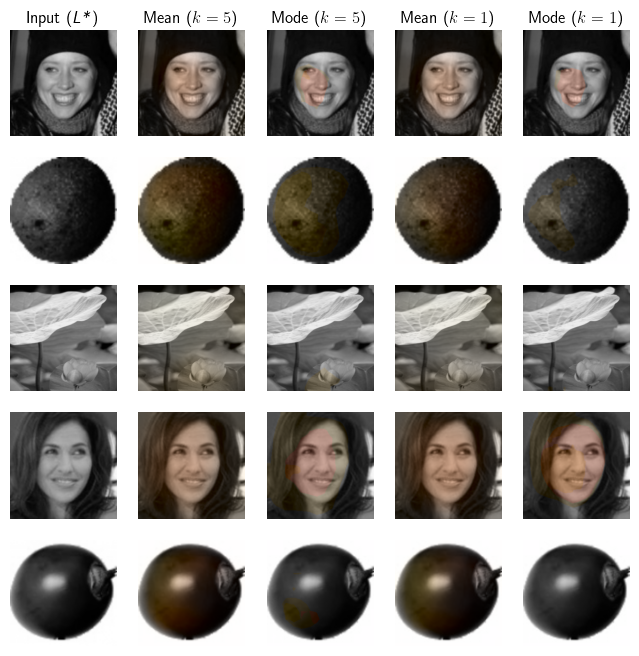

In [25]:
show_sample_results()